In [1]:
%%capture
!pip install -r requirements.txt

In [2]:
import sys
from pathlib import Path
import json
import pandas as pd
from dotenv import load_dotenv
import plotly.express as px
import torch as t
import pandas as pd
from tools.globals import load_country_globals

from translate import Translator

from nnsight import LanguageModel
from transformers import AutoTokenizer
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory
from tabulate import tabulate

from tools.nnsight_utils import collect_residuals, visualize_top_tokens
from tools.patchscope import patch_scope_gen
from tools.sae import display_dashboard

load_country_globals()
translator = Translator(from_lang="autodetect",to_lang="en")

device = t.device(
    "mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu"
)
load_dotenv()
t.set_grad_enabled(False)

t.manual_seed(42)
if t.cuda.is_available():
    t.cuda.manual_seed_all(42)

%load_ext autoreload
%autoreload 2

In [4]:
from sae_lens import HookedSAETransformer, SAE

model = HookedSAETransformer.from_pretrained('gemma-2-9b-it', 
                                                        device=device,
                                                        torch_dtype=t.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b-it")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-9b-it into HookedTransformer


In [5]:
sae_release = "gemma-scope-9b-pt-res-canonical"
sae_id = "layer_22/width_131k/canonical"

sae, cfg_dict, sparsity = SAE.from_pretrained(release=sae_release, sae_id=sae_id, device=device)

In [21]:
prefix = "tr"

res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_en_tr_hint_bal.pt")
res_en = t.load(f"residuals/gemma2_9b_it/{prefix}_en_no_hint_bal.pt")

steering_vec = (res_tr - res_en).mean(dim=0)
steering_vec = steering_vec.unsqueeze(1)

original_vec = steering_vec[22,:]

/tmp/ipykernel_2797/2533723538.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_en_tr_hint_bal.pt")
/tmp/ipykernel_2797/

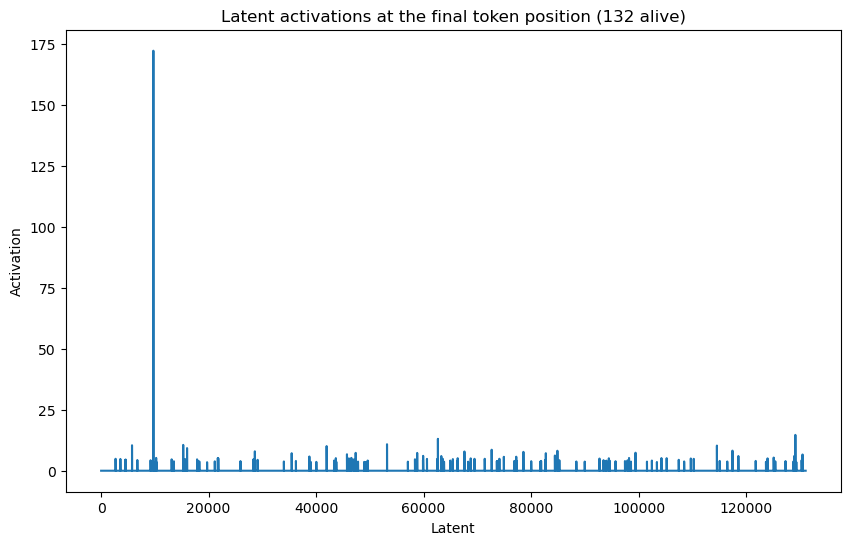

Latent 9718 had activation 172.12
Latent 129153 had activation 14.69
Latent 62653 had activation 13.07
Latent 53185 had activation 10.85
Latent 15271 had activation 10.58
Latent 5747 had activation 10.43
Latent 114557 had activation 10.30
Latent 41951 had activation 10.10
Latent 15986 had activation 9.27
Latent 72652 had activation 8.61
Latent 117451 had activation 8.23
Latent 84883 had activation 8.19
Latent 28597 had activation 7.95
Latent 67587 had activation 7.88
Latent 78561 had activation 7.74
Latent 99416 had activation 7.38
Latent 47353 had activation 7.33
Latent 58799 had activation 7.29
Latent 82729 had activation 7.18
Latent 35449 had activation 7.18
Latent 45734 had activation 6.74
Latent 130487 had activation 6.65
Latent 84417 had activation 6.23
Latent 59907 had activation 6.09
Latent 118549 had activation 6.03
Latent 63281 had activation 6.02
Latent 128932 had activation 6.01
Latent 38741 had activation 5.83
Latent 77228 had activation 5.74
Latent 74918 had activation 5.

In [22]:
import matplotlib.pyplot as plt
from tools.sae import display_dashboard


vec_slice = model.blocks[22].ln2(original_vec)


sae_acts_post = sae.encode(original_vec.squeeze(0))
#sae_acts_post = sae.encode(vec_slice.squeeze(0))

# Plot the latent activations
plt.figure(figsize=(10, 6))
plt.plot(sae_acts_post.cpu().numpy())
plt.title(f"Latent activations at the final token position ({sae_acts_post.nonzero().numel()} alive)")
plt.xlabel("Latent")
plt.ylabel("Activation")
plt.show()

# Print the top 3 latents, and inspect their dashboards
top_activations, top_indices = sae_acts_post.topk(50, largest=True)

for act, ind in zip(top_activations, top_indices):
    print(f"Latent {ind.item()} had activation {act.item():.2f}")
    #display_dashboard(latent_idx=ind.item(), sae_release=sae_release, sae_id=sae_id)

In [23]:
z = t.nn.Parameter(sae_acts_post, requires_grad=True)

In [24]:
for param in model.parameters():
    param.requires_grad = False

In [25]:
def injection_hook(module, input, output):
    # output shape is [batch_size, seq_len, hidden_dim]
    # decode z
    #z = model.blocks[22].ln2(z)
    decoded = sae.decode(z)                        # [hidden_dim]
    decoded = decoded.unsqueeze(0).unsqueeze(1) # [1,1,hidden_dim]
    decoded = decoded.expand(output.size(0), 1, -1)  # [batch_size, 1, hidden_dim]
    decoded = t.cat([t.zeros_like(output[:, :-1, :]), decoded], dim=1)  # [batch_size, seq_len, hidden_dim]
    return output + 4 * decoded  # broadcast add

In [ ]:
model.blocks[22].hook_resid_post

In [10]:
model.blocks[22].hook_resid_post.register_forward_hook(injection_hook)

In [11]:
optimizer = t.optim.Adam(
    [z],
    lr=1e-3
)

In [12]:
data_df = pd.read_csv("data/final_data_filtered.csv")
prompt_suffix = {
    "English": "My guess is **",
    "Turkish": "Tahminim **",
    "French": "Ma supposition est **",
    "Russian": "Моё предположение **",
    "Bengali": "আমার অনুমান হলো **",
}

df = data_df.query("country=='Turkey' and hint=='none'").copy()

df["text"] = data_df.apply(lambda x: f"{x['input']}{prompt_suffix[x['lang']]}", axis=1)
df["label"] = data_df["ans_local"].apply(lambda x: x+"**")

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyTextDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row["text"]
        label = row["label"]  # integer class
        # tokenize
        tokenized = self.tokenizer(
            text, 
            truncation=True, 
            padding="max_length",
            add_special_tokens=False,
            return_tensors="pt"
        )
        # for classification, we might not need to shift labels as in next-token LM
        return {
            "input_ids": tokenized["input_ids"].squeeze(0),
            "attention_mask": tokenized["attention_mask"].squeeze(0),
            "label": tokenizer(label, add_special_tokens=False)
        }

dataset = MyTextDataset(df.sample(400), tokenizer)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [22]:
cross_entropy = t.nn.CrossEntropyLoss()

def lm_loss_function(logits, targets):
    # logits: [batch_size, seq_len, vocab_size]
    # targets: [batch_size, seq_len]
    # Typically we shift targets by 1 for next-token prediction, etc.
    return cross_entropy(logits, targets)

In [45]:
def l1_penalty_z(z):
    # z is [latent_dim]
    # sum |z_i| over i where mask[i] == True
    return (z.abs()).sum()


In [16]:

def alignment_penalty(decoded, ref):
    return t.nn.functional.mse_loss(decoded, ref)

In [56]:
lambda_ce = 1.0
lambda_l0 = 0.01
lambda_align = 0.0

def combined_loss_fn(logits, targets, z, reference_vector):
    loss_ce = lm_loss_function(logits, targets)
    loss_l0 = l1_penalty_z(z)  # or a better approach
    decoded = sae.decode(z)
    loss_align = alignment_penalty(decoded, reference_vector)
    return (lambda_ce * loss_ce
            + lambda_l0 * loss_l0
            + lambda_align * loss_align)

In [57]:
import torch
import torch.nn as nn

latent_dim = sae_acts_post.size(0)

# Example mask: 1 = trainable, 0 = frozen
trainable_mask = sae_acts_post > 0

def zero_grad_frozen_dims(param, mask):
    """
    In-place zero out gradient for positions we want to freeze.
    This ensures those positions don't update even if they have gradients.
    """
    if param.grad is not None:
        param.grad[~mask] = 0.0


In [59]:
from tqdm import tqdm

# Put decoder & z on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#decoder = decoder.to(device)
z = nn.Parameter(z.to(device))

reference_vector = original_vec.to(device)  # shape [hidden_dim]

optimizer = torch.optim.Adam(
    [z], 
    lr=1e-3
)

num_epochs = 3

model.eval()  # The LLM is frozen anyway; if there's dropout or LayerNorm, you might keep it in eval

for epoch in range(num_epochs):
    for batch in tqdm(dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        label = batch["label"]["input_ids"][-1].to(device)

        optimizer.zero_grad()

        # Forward pass => injection_hook => hidden + decoder(z)
        # We'll assume the model outputs classification logits
        
        outputs = model(input_ids, attention_mask=attention_mask).to(device)
        # For some HuggingFace models, logits might be in outputs.logits
        logits = outputs  # [batch_size, num_classes]

        # Compute combined loss
        loss = combined_loss_fn(logits[:,-1,:], label, z, reference_vector)

        loss.requires_grad = True
        loss.backward()

        # Zero grad in the frozen dims of z
        #zero_grad_frozen_dims(z, trainable_mask)

        optimizer.step()


    print(f"Epoch {epoch} finished. Last batch loss = {loss.item():.4f}")


  0%|          | 0/1070 [00:00<?, ?it/s]/tmp/ipykernel_1690/1713747666.py:2: UserWarning: Using a target size (torch.Size([1, 3584])) that is different to the input size (torch.Size([3584])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return t.nn.functional.mse_loss(decoded, ref)
100%|██████████| 1070/1070 [02:35<00:00,  6.90it/s]


Epoch 0 finished. Last batch loss = 18.7556


100%|██████████| 1070/1070 [02:31<00:00,  7.08it/s]


Epoch 1 finished. Last batch loss = 22.2556


 29%|██▉       | 308/1070 [00:43<01:47,  7.11it/s]


KeyboardInterrupt: 

In [52]:
sae_acts_post.topk(50, largest=True)

torch.return_types.topk(
values=tensor([172.1247,  14.6867,  13.0734,  10.8545,  10.5843,  10.4345,  10.2991,
         10.0962,   9.2711,   8.6055,   8.2304,   8.1877,   7.9508,   7.8799,
          7.7355,   7.3832,   7.3284,   7.2882,   7.1823,   7.1800,   6.7441,
          6.6518,   6.2257,   6.0919,   6.0255,   6.0239,   6.0124,   5.8300,
          5.7418,   5.7088,   5.5028,   5.3875,   5.2589,   5.2533,   5.2270,
          5.2143,   5.1799,   5.1547,   5.1454,   5.1334,   5.0992,   5.0874,
          5.0643,   5.0615,   5.0140,   4.9867,   4.9637,   4.9062,   4.9061,
          4.8974], device='cuda:0'),
indices=tensor([  9718, 129153,  62653,  53185,  15271,   5747, 114557,  41951,  15986,
         72652, 117451,  84883,  28597,  67587,  78561,  99416,  47353,  58799,
         82729,  35449,  45734, 130487,  84417,  59907, 118549,  63281, 128932,
         38741,  77228,  74918,  45785, 125119,  46554,  10238,  98210,  21706,
        104236,  43662, 105209,  66332,  94452,  21799,  

In [62]:
(sae_acts_post == z).sum()

tensor(131072, device='cuda:0')

In [60]:
z.topk(50, largest=True)

torch.return_types.topk(
values=tensor([172.1247,  14.6867,  13.0734,  10.8545,  10.5843,  10.4345,  10.2991,
         10.0962,   9.2711,   8.6055,   8.2304,   8.1877,   7.9508,   7.8799,
          7.7355,   7.3832,   7.3284,   7.2882,   7.1823,   7.1800,   6.7441,
          6.6518,   6.2257,   6.0919,   6.0255,   6.0239,   6.0124,   5.8300,
          5.7418,   5.7088,   5.5028,   5.3875,   5.2589,   5.2533,   5.2270,
          5.2143,   5.1799,   5.1547,   5.1454,   5.1334,   5.0992,   5.0874,
          5.0643,   5.0615,   5.0140,   4.9867,   4.9637,   4.9062,   4.9061,
          4.8974], device='cuda:0'),
indices=tensor([  9718, 129153,  62653,  53185,  15271,   5747, 114557,  41951,  15986,
         72652, 117451,  84883,  28597,  67587,  78561,  99416,  47353,  58799,
         82729,  35449,  45734, 130487,  84417,  59907, 118549,  63281, 128932,
         38741,  77228,  74918,  45785, 125119,  46554,  10238,  98210,  21706,
        104236,  43662, 105209,  66332,  94452,  21799,  

In [38]:
logits.shape

torch.Size([1, 65, 256000])

In [40]:
label.shape

torch.Size([1])

In [36]:
logits

tensor([[[-26.1250,  17.3750,  21.2500,  ..., -10.4375,  -3.5781, -13.8750],
         [-24.3750,   4.1562, -16.3750,  ..., -13.4375, -10.7500, -25.2500],
         [-25.3750,   2.9375, -17.7500,  ..., -14.4375, -11.4375, -26.1250],
         ...,
         [-27.1250,  -1.1875,   0.1836,  ..., -12.1250, -15.0000, -26.7500],
         [-13.4375,   0.1699,  -4.4375,  ...,  -5.7188,  -5.8750, -13.6250],
         [-14.1250,  -1.3047,   6.3438,  ...,  -7.4062,  -7.5000, -15.6875]]],
       device='cuda:0', dtype=torch.bfloat16)

In [34]:
labels["input_ids"][-1].device

device(type='cpu')

In [30]:
device

device(type='cuda')

In [24]:
labels

{'input_ids': [tensor([5523]), tensor([14132]), tensor([23398]), tensor([8155]), tensor([688])], 'attention_mask': [tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1])]}

In [25]:
outputs.shape

torch.Size([1, 64, 256000])